<b><font size =20> Finding connected components in graph </font>

<b><font> Victoire de Termont, Sarah Jallot, Naomi Serfaty 
</font>

# 1. Open a Spark session and import packages

In [1]:
# Regular packages
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore") # might not be the best idea

In [2]:
# pyspark packages 
from pyspark.sql.functions import col, concat, collect_list,struct
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.functions import udf, array, array_distinct, array_min,array_max,array_union, explode
from pyspark.sql.types import IntegerType, DoubleType, ArrayType

from pyspark import SparkContext
from pyspark.sql import Row

In [3]:
sc = SparkContext()

In [4]:
spark = SparkSession.builder.appName('abc').getOrCreate()

# 2. Define functions to find connected components in graph with RDD 

In [28]:
def file_to_rdd(file):
    """
    This function takes a file name and converts it into an RDD.
    
    Arguments:
    file (str): file name
    
    Returns:
    An RDD containing all information extracted from the file.
    """

    if file[-3:] == "csv" : 
        data = spark.read.format("csv").option("inferSchema", "true")\
                                        .option("delimiter", ',')\
                                        .option("header", 'true')\
                                        .load(file).cache()

        rdd = adj_cache.rdd.map(tuple)
        return rdd
    elif file[-3:] == "txt" : 
        rdd_web = sc.textFile(file) \
                    .map(lambda line: line.split('\t')) \
                    .filter(lambda line: len(line)>1) \
                        .map(lambda line: (line[0],line[1]))

        return rdd_web

In [7]:
def CCF_DEDUP_rdd(rdd):
    """
    This function takes an RDD and returns for each component the closest
    connected neighbor, in one way or the other: we can have (a,b) or (b,a), or both.
    It is inspired from the CCF_iterate and and the CCF_Dedup found 
    in the article https://www.cse.unr.edu/~hkardes/pdfs/ccf.pdf
    
    Arguments:
    rdd (rdd): rdd name
    
    Returns:
    An RDD containing for each component the closest connected 
    neighbor(direct relationship only),in one way or the other. 
    """
    
    # Our goal is to list all existing edges in both ways: (k,v) and (v,k)
    # Our called RDD contains all (k,v) and we want to add all (v,k)
    
    rdd_reverse = rdd.map(lambda x :(x[1], x[0])) # getting all (v,k)
    rdd_0 = rdd.union(rdd_reverse) # Building a new RDD containing all (k,v) and (v,k)
    
    # Grouping by key on the first element (k, [v1, v2...])
    rdd_1 = rdd_0.groupByKey().map(lambda x : (x[0], list(x[1])))
    
    # New k: the minimum between k and all elements included in v 
    # New v: all values from k and v
    rdd_2 = rdd_1.map(lambda x : (min(x[0], min(x[1])),  list(set(x[1] + [x[0]]))))
    
    # Extracting each element of v as our key k and assigning it the corresponding minimum found above
    rdd_3 = rdd_2.flatMapValues(lambda x : x).map(lambda x : (x[1], x[0])).distinct()
    
    return rdd_3

In [8]:
def get_groups_rdd(rdd):
    """
    This function extracts connected components from an RDD, and assigns
    the smallest component value of each group as the group name. 
    
    Arguments:
    rdd (rdd): rdd name
    
    Returns:
    t (float) : Computational Time
    size (int) : Total number of distinct edges in the input graph
    num_of_groups (int) : Number of groups of connected components
    rdd (rdd) : An RDD containing as many tuples as the number of unique components in 
    the original RDD: the key is the component and the value is the group name.
    """
    
    #Count of edges 
    rdd_reverse = rdd.map(lambda x :(x[1], x[0])) # getting all (v,k)
    rdd_0 = rdd.union(rdd_reverse) # Building a new RDD containing all (k,v) and (v,k)
    size = (rdd_0.distinct()).count()/2
    
    # Final number of tuples must be equal to the number of distinct values in our original RDD
    # And we can prove that they are equal only once the solution is found 
    t = time.time()
    
    #The counter counts the number of times the algorithm goes through the loop
    #It will depend on the maximum distance between two components of the same group
    counter = 0
    while rdd.count()!= (rdd.groupBy(lambda x : x[0]).distinct()).count() :
        counter +=1
        rdd = CCF_DEDUP_rdd(rdd) # function explained above 
    t = time.time() - t
       
    #Getting the number of groups of connected components
    num_of_groups = len(rdd.values().distinct().collect())
    
    return t, size, num_of_groups, counter, rdd

# 3. Define functions to find connected components in graph with DataFrame

In [13]:
def file_to_df(file):
    """
    This function takes a file name and converts it into a DataFrame.
    
    Arguments:
    file (str): file name
    
    Returns:
    An DataFrame containing all information extracted from the file.
    """
    
    if file[-3:] == "csv" : 
        data = spark.read.format("csv").option("inferSchema", "true")\
                                        .option("delimiter", ',')\
                                        .option("header", 'true')\
                                        .load(file).toDF("To","From").cache()

        return adj_cache
    elif file[-3:] == "txt" : 
        df_web = sc.textFile(file) \
            .map(lambda line: (line.split('\t'))).toDF()\
            .select(col('_1').cast(IntegerType()).alias('To'), col('_2').cast(IntegerType()).alias('From'))

        #Remove header if there
        #df_web = df_web.filter(df_web.To !='FromNodeId' )

        return df_web

In [10]:
# Version working locally but not on RosettaHub
def CCF_DEDUP_df_old(df):
    """
    This function takes an DataFrame and returns for each component the closest
    connected neighbor, in one way or the other: we can have (a,b) or (b,a), or both.
    It is inspired from the CCF_iterate and and the CCF_Dedup found 
    in the article https://www.cse.unr.edu/~hkardes/pdfs/ccf.pdf
    
    Arguments:
    df (df): DataFrame name
    
    Returns:
    An DataFrame containing for each component the closest connected 
    neighbor(direct relationship only),in one way or the other. 
    """

    # Our goal is to list all existing edges in both ways: (k,v) and (v,k)
    # Our called RDD contains all (k,v) and we want to add all (v,k)
    reverseDF = df.select(col("From").alias("To"),col("To").alias("From"))# getting all (v,k)
    df_0 = df.union(reverseDF)# Building a new DataFrame containing all (k,v) and (v,k)
    
    # Grouping by key on the first element (k, [v1, v2...])
    df_1 = df_0.groupBy(col("To")).agg(f.array_distinct(collect_list(col("From"))).alias('From'))
    
    # New k: the minimum between k and all elements included in v 
    # New v: all values from k and v
    df_2 = df_1.withColumn('From', array_union(df_1.From, array(df_1.To))).withColumn('To', array_min("From"))
    
    # Extracting each element of v as our key k and assigning it the corresponding minimum found above
    df_3 = df_2.select( explode(col("From")).alias("To"), col("To").alias("From")).dropDuplicates()
    
    return df_3

In [11]:
# Redefining functions that RosettaHub could not read
def our_union (x):
    x[1].append(x[0])
    return x[1]

our_union_udf = f.udf(our_union, ArrayType(IntegerType()))
findmin = f.udf(lambda x: min(x), IntegerType())
our_distinct = f.udf(lambda x: list(set(x)), ArrayType(IntegerType()))

# New function working on RosettaHub
def CCF_DEDUP_df(df):
    """
    This function takes an DataFrame and returns for each component the closest
    connected neighbor, in one way or the other: we can have (a,b) or (b,a), or both.
    It is inspired from the CCF_iterate and and the CCF_Dedup found 
    in the article https://www.cse.unr.edu/~hkardes/pdfs/ccf.pdf
    
    Arguments:
    df (df): DataFrame name
    
    Returns:
    An DataFrame containing for each component the closest connected 
    neighbor(direct relationship only),in one way or the other. 
    """

    # Our goal is to list all existing edges in both ways: (k,v) and (v,k)
    # Our called RDD contains all (k,v) and we want to add all (v,k)
    reverseDF = df.select(col("From").alias("To"),col("To").alias("From"))# getting all (v,k)
    df_0 = df.union(reverseDF)# Building a new DataFrame containing all (k,v) and (v,k)
    
    # Grouping by key on the first element (k, [v1, v2...])
    df_1 = df_0.groupBy(col("To")).agg(our_distinct(collect_list(col("From"))).alias('From'))
    
    # New k: the minimum between k and all elements included in v 
    # New v: all values from k and v
    #df_2 = df_1.withColumn('From', array_union(df_1.From, array(df_1.To))).withColumn('To', findmin("From"))
    df_2 = df_1.withColumn('From', our_union_udf(struct(df_1.To, df_1.From)))\
                    .withColumn('To', findmin("From"))\
                        .withColumn('From', our_distinct('From'))
    
    # Extracting each element of v as our key k and assigning it the corresponding minimum found above
    df_3 = df_2.select( explode(col("From")).alias("To"), col("To").alias("From")).dropDuplicates()
    
    return df_3

In [12]:
def get_groups_df(df):
    """
    This function extracts connected components from a DataFrame, and assigns
    the smallest component value of each group as the group name. 
    
    Arguments:
    df (df): DataFrame name
    
    Returns:
    t (float) : Computational Time
    size (int) : Total number of distinct edges in the input graph
    num_of_groups (int) : Number of groups of connected components
    df (DataFrame) : An DataFrame containing as many tuples as the number of unique components in 
    the original DataFrame: the key is the component and the value is the group name.
    """
    
    #Count of edges 
    reverseDF = df.select(col("From").alias("To"),col("To").alias("From")) # getting all (v,k)
    df_0 = df.union(reverseDF)# Building a new DataFrame containing all (k,v) and (v,k)
    size = df_0.distinct().count()/2
    
    # Final number of tuples must be equal to the number of distinct values in our original RDD
    # And we can prove that they are equal only once the solution is found 
    t = time.time()
    
    #Counter measures the max distance between two neighboors of the group 
    counter = 0 
    while df.count()!= df.select('To').distinct().count() :
        counter +=1 
        df = CCF_DEDUP_df(df) # function explained above 
    t = time.time() - t
    
    #Getting the number of groups of connected components
    num_of_groups = len(df.select('From').distinct().collect())
    
    return t, size,num_of_groups, counter,  df

# 4. Graph of Size VS Speed

### Our Graphs

##### RDD : Our graphs

In [243]:
#Create DataFrame to store size of graph, and computation time
res_RDD = pd.DataFrame(index=["Num of Edges",'Num of Groups',"#of indirect neighboors", "Computational time (RDD)"])

#For each file save info to DataFrame
for file in ["File/web_w.csv", "File/web_NotOk.csv", "File/web_OK.csv", "File/web-Google_short.txt"]:
    rdd = file_to_rdd(file)
    t, size, num_of_groups, counter, rdd = get_groups_rdd(rdd)
    res_RDD.loc[:, file] = (round(size), round(num_of_groups), counter, round(t,3))
res_RDD = res_RDD.sort_values('Num of Edges',axis=1)
res_RDD

,File/web_w.csv,File/web_OK.csv,File/web_NotOk.csv,File/web-Google_short.txt
Num of Edges,3.000,8.000,23.000,41.00
Num of Groups,1.000,2.000,3.000,1.00
#of indirect neighboors,3.000,2.000,5.000,2.00
Computational time (RDD),0.979,0.519,2.649,0.76


In [244]:
res_RDD.columns=['Graph_1', "Graph_2", 'Graph_3', 'Graph_4']

In [245]:
res_RDD

,Graph_1,Graph_2,Graph_3,Graph_4
Num of Edges,3.000,8.000,23.000,41.00
Num of Groups,1.000,2.000,3.000,1.00
#of indirect neighboors,3.000,2.000,5.000,2.00
Computational time (RDD),0.979,0.519,2.649,0.76


##### Dataframe : Our Graphs


In [235]:
#Create DataFrame to store size of graph, and computation time
res_DF = pd.DataFrame(index=["Num of Edges",'Num of Groups', "#of indirect neighboors","Computational time (DF)"])

#For each file save info to DataFrame
for file in ["File/web_w.csv", "File/web_NotOk.csv", "File/web_OK.csv", "File/web-Google_short.txt"]:
    df = file_to_df(file)
    t, size, num_of_groups,counter,  df = get_groups_df(df)
    res_DF.loc[:, file] = (round(size), round(num_of_groups),counter,  round(t,3))
res_DF = res_DF.sort_values('Num of Edges',axis=1)
res_DF

,File/web_w.csv,File/web_OK.csv,File/web_NotOk.csv,File/web-Google_short.txt
Num of Edges,3.000,8.000,23.000,44.000
Num of Groups,1.000,2.000,3.000,1.000
#of indirect neighboors (DF),3.000,2.000,5.000,2.000
Computational time (DF),13.684,7.404,24.715,10.718


In [236]:
res_DF.columns=['Graph_1', "Graph_2", 'Graph_3', 'Graph_4']

In [237]:
res_DF

,Graph_1,Graph_2,Graph_3,Graph_4
Num of Edges,3.000,8.000,23.000,44.000
Num of Groups,1.000,2.000,3.000,1.000
#of indirect neighboors (DF),3.000,2.000,5.000,2.000
Computational time (DF),13.684,7.404,24.715,10.718


###### Combinaison

In [246]:
res_RDD.loc['Computational time (DF)',:] = res_DF.loc['Computational time (DF)']

In [247]:
res_RDD

,Graph_1,Graph_2,Graph_3,Graph_4
Num of Edges,3.000,8.000,23.000,41.000
Num of Groups,1.000,2.000,3.000,1.000
#of indirect neighboors,3.000,2.000,5.000,2.000
Computational time (RDD),0.979,0.519,2.649,0.760
Computational time (DF),13.684,7.404,24.715,10.718


### Google Graphs

###### RDD : Google Graph

In [207]:
res_RDD_Google = pd.DataFrame(index=["Num of Edges",'Num of Groups (RDD)',"Computational time (RDD)"])

In [208]:
res_RDD_Google.loc[:,"web-Google_FULL"] = (4322051,2746, round(1255.32816601))
res_RDD_Google.loc[:,"web-Google_DEMI"] = (2039129,4135, round(614.631679843))
res_RDD_Google.loc[:,"web-Google_QUART"] = (1014822,2743, round(386.780790091))

In [209]:
res_RDD_Google

,web-Google_FULL,web-Google_DEMI,web-Google_QUART
Num of Edges,4322051,2039129,1014822
Num of Groups (RDD),2746,4135,2743
Computational time (RDD),1255,615,387


###### DataFrame : Google Graph

In [215]:
res_DF_Google = pd.DataFrame(index=["Num of Edges",'Num of Groups (DF)',"Computational time (DF)"])

In [216]:
res_DF_Google.loc[:,"web-Google_FULL"] = (4322051, 2746, round(1745.23199582))
res_DF_Google.loc[:,"web-Google_DEMI"] = (2039129, 4135, round(886.50760576))
res_DF_Google.loc[:,"web-Google_QUART"] = (1014822, 2743, round(573.251643896))

In [217]:
res_DF_Google

,web-Google_FULL,web-Google_DEMI,web-Google_QUART
Num of Edges,4322051,2039129,1014822
Num of Groups (DF),2746,4135,2743
Computational time (DF),1745,887,573


##### Combinaison

In [219]:
res_RDD_Google.loc['Num of Groups (DF)',:] = res_DF_Google.loc['Num of Groups (DF)']
res_RDD_Google.loc['Computational time (DF)',:] = res_DF_Google.loc['Computational time (DF)']

In [220]:
print(res_RDD_Google)

,web-Google_FULL,web-Google_DEMI,web-Google_QUART
Num of Edges,4322051.0,2039129.0,1014822.0
Num of Groups (RDD),2746.0,4135.0,2743.0
Computational time (RDD),1255.0,615.0,387.0
Num of Groups (DF),2746.0,4135.0,2743.0
Computational time (DF),1745.0,887.0,573.0


##### Plot of Speed VS Rating 

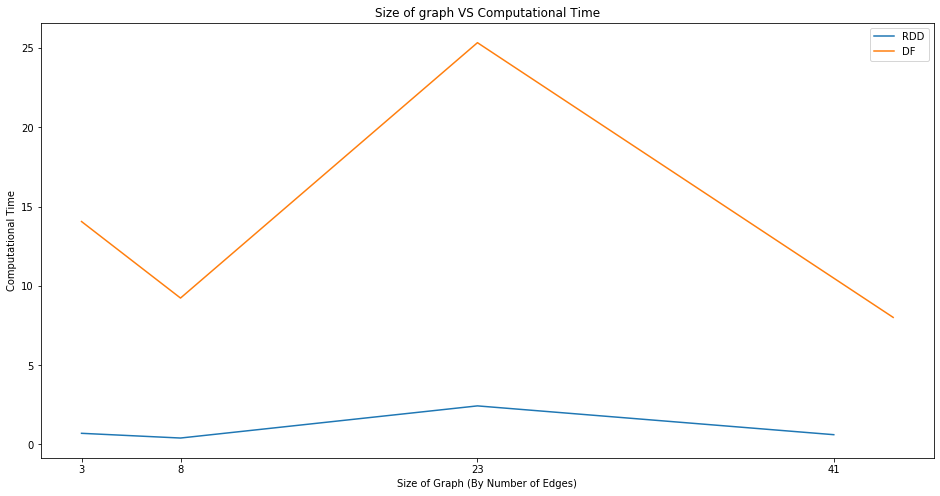

In [203]:
plt.figure(figsize=(16,8))
plt.plot(res_RDD.loc['Num of Edges'], res_RDD.loc['Computational time (RDD)'], label = "RDD")
plt.plot(res_DF.loc['Num of Edges'], res_DF.loc['Computational time (DF)'], label = "DF")
plt.legend(loc='best')
#plt.yticks(res_RDD.loc['Computational time (RDD)'])
plt.xticks(res_RDD.loc['Num of Edges'])
plt.ylabel('Computational Time')
plt.xlabel('Size of Graph (By Number of Edges)')
plt.title('Size of graph VS Computational Time')
plt.show()

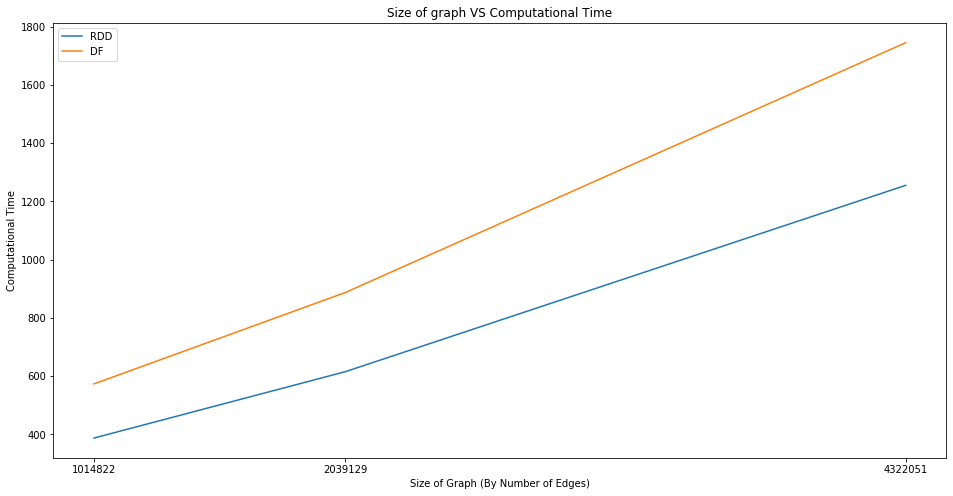

In [224]:
plt.figure(figsize=(16,8))
plt.plot(res_RDD_Google.loc['Num of Edges'], res_RDD_Google.loc['Computational time (RDD)'], label = "RDD")
plt.plot(res_DF_Google.loc['Num of Edges'], res_DF_Google.loc['Computational time (DF)'], label = "DF")
plt.legend(loc='best')
#plt.yticks(res_RDD_Google.loc['Computational time (RDD)'])
plt.xticks(res_RDD_Google.loc['Num of Edges'])
plt.ylabel('Computational Time')
plt.xlabel('Size of Graph (By Number of Edges)')
plt.title('Size of graph VS Computational Time')
plt.show()

# 5. More graphs for our own understanding

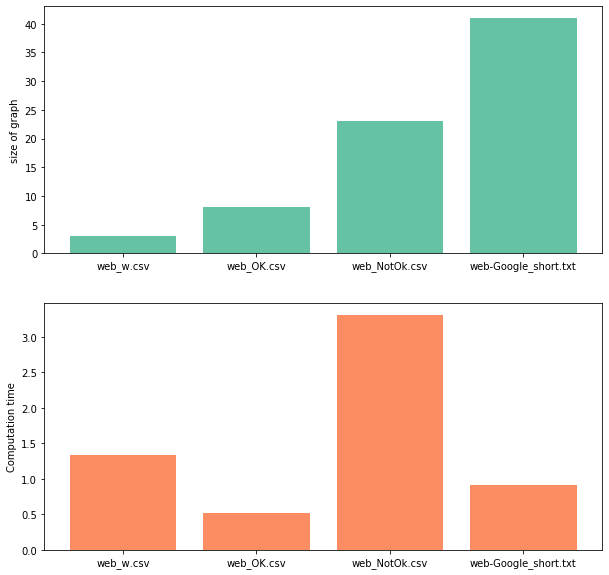

In [72]:
# Other graphs to see the correlation between size of graph and run-time for our small files 
plt.close("all")
fig, ax = plt.subplots(2, figsize=(10, 10)) 
for i in range(len(res_RDD.index)):
    ax[i].bar(res_RDD.columns.tolist(), res_RDD.iloc[i], color=plt.cm.Set2(i)) 
    ax[i].axhline(color="k", linewidth=plt.rcParams["axes.linewidth"]) 
    ax[i].set_ylabel(res_RDD.index[i])
plt.show() 

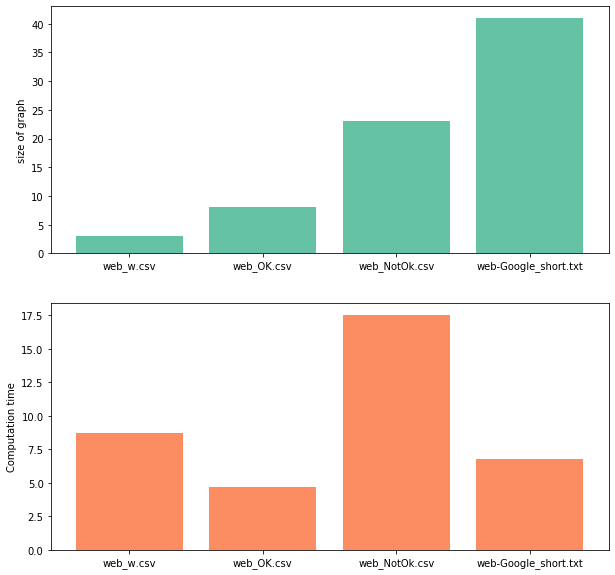

In [73]:
# Other graphs to see the correlation between size of graph and run-time for web-Google graphs 
plt.close("all")
fig, ax = plt.subplots(2, figsize=(10, 10)) 
for i in range(len(res_DF.index)):
    ax[i].bar(res_DF.columns.tolist(), res_DF.iloc[i], color=plt.cm.Set2(i)) 
    ax[i].axhline(color="k", linewidth=plt.rcParams["axes.linewidth"]) 
    ax[i].set_ylabel(res_DF.index[i])
plt.show() 